In [1]:
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model

In [2]:
image_directory = r'D:\Projects\ODIR\ODIRCODE\PreprocessingCodes\Input_224/'


#Now let us read metadata to get our Y values (multiple lables)
df = pd.read_csv(r'D:\Projects\ODIR\ODIRCODE\Prepro\ground_truth\all\odirALL.csv')    
print(df.head())     # printing first five rows of the file
print(df.columns)

df = df.iloc[:23000]  #Loading only first 1000 datapoints for memory reasons 
#Need to read images using the tag from metadata.
#Otherwise, if read directly from the folder then images may not correspond to 
#the metadata from the csv file. 

            ID  Normal  Diabetes  Glaucoma  Cataract  AMD  Hypertension  \
0   0_left.jpg       0         0         0         1    0             0   
1  0_right.jpg       1         0         0         0    0             0   
2   1_left.jpg       1         0         0         0    0             0   
3  1_right.jpg       1         0         0         0    0             0   
4   2_left.jpg       0         1         0         0    0             0   

   Myopia  Others  Total  
0       0       0      1  
1       0       0      1  
2       0       0      1  
3       0       0      1  
4       0       1      2  
Index(['ID', 'Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD',
       'Hypertension', 'Myopia', 'Others', 'Total'],
      dtype='object')


In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
SIZE = 224
X_dataset = []  
for i in tqdm(range(df.shape[0])):
    img = load_img(image_directory +df['ID'][i], target_size=(SIZE,SIZE,3))   
    img = img_to_array(img)
    img = img/255.
    X_dataset.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 22032/22032 [01:27<00:00, 251.02it/s]


In [4]:
X = np.array(X_dataset)

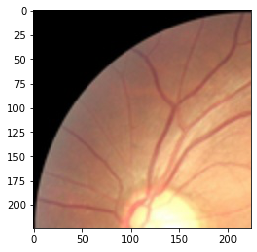

In [5]:
from matplotlib import pyplot as plt
plt.imshow(X[21000], interpolation='nearest')
plt.show()

In [6]:
#
print(df['ID'][500])  #King Kong

print(df['Total'][500])  #Tagged as multiple Genres.

#Id and Genre are not labels to be trained. So drop them from the dataframe.

268_left.jpg
2


In [7]:
y = np.array(df.drop(['ID', 'Total'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [8]:
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten
checkpoint1 = ModelCheckpoint(filepath=r'D:\Projects\ODIR\ODIRCODE\bestres\IncResV2\my_best_model.epoch{epoch:03d}-loss{val_loss:.2f}.hdf5', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
checkpoint2 = ModelCheckpoint(filepath=r'D:\Projects\ODIR\ODIRCODE\bestres\IncResV2\my_best_model.epoch{epoch:03d}-acc{val_accuracy:.2f}.hdf5', 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

callbacks = [checkpoint1,checkpoint2]
IncResV2 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=8
)

  #  classifier_activation="softmax",
 #   **kwargs
#res=tf.keras.applications.resnet.ResNet101(include_top=False,weights='imagenet',input_tensor=None,
   # input_shape=(224,224,3),
 #   pooling=None,
  #  classes=8)

#inc=InceptionV3(input_shape=(200,200,3),weights='imagenet', include_top=False)
for i in IncResV2.layers:
    i.trainable=True
x=Flatten()(IncResV2.output)
pred=Dense(8,activation='sigmoid')(x)
model=Model(inputs=IncResV2.input,outputs=pred)

219062272/219055592 [==============================] - 39s 0us/step


In [9]:
model.summary()

#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=150,callbacks=callbacks, validation_data=(X_test, y_test), batch_size=10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Train on 15422 samples, validate on 6610 samples
Epoch 1/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.4253 - accuracy: 0.8579
Epoch 00001: val_loss improved from inf to 0.60549, saving model to D:\Projects\ODIR\ODIRCODE\bestres\IncResV2\my_best_model.epoch001-loss0.61.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.87479, saving model to D:\Projects\ODIR\ODIRCODE\bestres\IncResV2\my_best_model.epoch001-acc0.87.hdf5
15422/15422 [==============================] - 221s 14ms/sample - loss: 0.4254 - accuracy: 0.8579 - val_loss: 0.6055 - val_accuracy: 0.8748
Epoch 2/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8786
Epoch 00002: val_loss did not improve from 0.60549

Epoch 00002: val_accuracy did not improve from 0.87479
15422/15422 [==============================] - 194s 13ms/sample - loss: 0.2978 - accuracy: 0.8786 - val_loss: 2.6215 - val_accuracy: 0.8704
Epoch 3/150
15420/15422 [============================>.] - ET

15420/15422 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9236
Epoch 00022: val_loss did not improve from 0.25996

Epoch 00022: val_accuracy improved from 0.89726 to 0.89966, saving model to D:\Projects\ODIR\ODIRCODE\bestres\IncResV2\my_best_model.epoch022-acc0.90.hdf5
15422/15422 [==============================] - 195s 13ms/sample - loss: 0.1794 - accuracy: 0.9236 - val_loss: 8.8673 - val_accuracy: 0.8997
Epoch 23/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.1635 - accuracy: 0.9306
Epoch 00023: val_loss did not improve from 0.25996

Epoch 00023: val_accuracy did not improve from 0.89966
15422/15422 [==============================] - 194s 13ms/sample - loss: 0.1635 - accuracy: 0.9306 - val_loss: 2.1163 - val_accuracy: 0.8921
Epoch 24/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy: 0.9377
Epoch 00024: val_loss did not improve from 0.25996

Epoch 00024: val_accuracy did not improve from 0.89966
15422/

Epoch 45/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9884
Epoch 00045: val_loss did not improve from 0.25996

Epoch 00045: val_accuracy did not improve from 0.90626
15422/15422 [==============================] - 193s 13ms/sample - loss: 0.0316 - accuracy: 0.9884 - val_loss: 10.2431 - val_accuracy: 0.9044
Epoch 46/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9930
Epoch 00046: val_loss did not improve from 0.25996

Epoch 00046: val_accuracy did not improve from 0.90626
15422/15422 [==============================] - 192s 12ms/sample - loss: 0.0194 - accuracy: 0.9930 - val_loss: 5.5375 - val_accuracy: 0.9044
Epoch 47/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9931
Epoch 00047: val_loss did not improve from 0.25996

Epoch 00047: val_accuracy did not improve from 0.90626
15422/15422 [==============================] - 192s 12ms/sample - loss: 0.0194 - accuracy: 0

15420/15422 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9961
Epoch 00068: val_loss did not improve from 0.25996

Epoch 00068: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0106 - accuracy: 0.9961 - val_loss: 16.9707 - val_accuracy: 0.9061
Epoch 69/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0483 - accuracy: 0.9829
Epoch 00069: val_loss did not improve from 0.25996

Epoch 00069: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0486 - accuracy: 0.9829 - val_loss: 8.6915 - val_accuracy: 0.8950
Epoch 70/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9912
Epoch 00070: val_loss did not improve from 0.25996

Epoch 00070: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0243 - accuracy: 0.9912 - val_l

Epoch 92/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9973
Epoch 00092: val_loss did not improve from 0.25996

Epoch 00092: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0081 - accuracy: 0.9973 - val_loss: 12.8742 - val_accuracy: 0.8962
Epoch 93/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9972
Epoch 00093: val_loss did not improve from 0.25996

Epoch 00093: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0081 - accuracy: 0.9972 - val_loss: 13.7275 - val_accuracy: 0.9008
Epoch 94/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9976
Epoch 00094: val_loss did not improve from 0.25996

Epoch 00094: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0067 - accuracy: 

Epoch 116/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9976
Epoch 00116: val_loss did not improve from 0.25996

Epoch 00116: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0077 - accuracy: 0.9976 - val_loss: 126.2201 - val_accuracy: 0.8998
Epoch 117/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9986
Epoch 00117: val_loss did not improve from 0.25996

Epoch 00117: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0041 - accuracy: 0.9986 - val_loss: 40.8459 - val_accuracy: 0.9052
Epoch 118/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0063 - accuracy: 0.9979
Epoch 00118: val_loss did not improve from 0.25996

Epoch 00118: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0063 - accura

Epoch 140/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9985
Epoch 00140: val_loss did not improve from 0.25996

Epoch 00140: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0048 - accuracy: 0.9985 - val_loss: 283.1351 - val_accuracy: 0.9018
Epoch 141/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9982
Epoch 00141: val_loss did not improve from 0.25996

Epoch 00141: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0053 - accuracy: 0.9982 - val_loss: 16.2823 - val_accuracy: 0.9012
Epoch 142/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9987
Epoch 00142: val_loss did not improve from 0.25996

Epoch 00142: val_accuracy did not improve from 0.90876
15422/15422 [==============================] - 191s 12ms/sample - loss: 0.0038 - accura

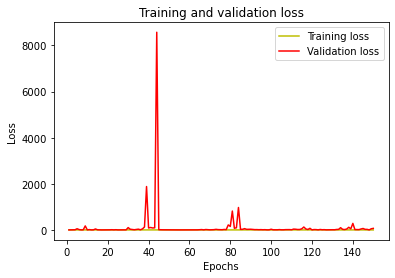

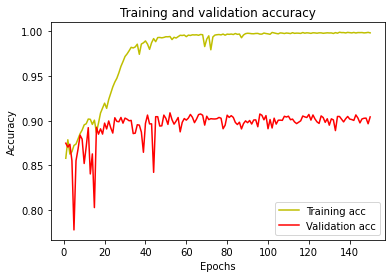

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
# MLP for Pima Indians Dataset saved to single file
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model.save(r"D:\Projects\ODIR\ODIRCODE\IncResV2\modelke.h5")
print("Saved model to disk")
# evaluate the model
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# save model and architecture to single file
model.save(r"D:\Projects\ODIR\ODIRCODE\IncResV2\ke2model.h5")
print("Saved model to disk")

Saved model to disk
accuracy: 99.05%
Saved model to disk


In [12]:
...
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, r"D:\Projects\ODIR\ODIRCODE\IncResV2\model2.h5")

In [14]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense
import numpy
import os

# evaluate the model
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 
# serialize model to JSON
model_json = model.to_json()
with open(r"D:\Projects\ODIR\ODIRCODE\IncResV2\model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(r"D:\Projects\ODIR\ODIRCODE\IncResV2\modeljs.h5")
print("Saved model to disk")


accuracy: 99.05%
Saved model to disk


In [15]:
from tensorflow.keras.models import Sequential, model_from_yaml
from tensorflow.keras.layers import Dense
import numpy
import os

# serialize model to YAML
model_yaml = model.to_yaml()
with open(r"D:\Projects\ODIR\ODIRCODE\IncResV2\model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(r"D:\Projects\ODIR\ODIRCODE\IncResV2\modelya.h5")
print("Saved model to disk")
 


Saved model to disk
